In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import MNIST, FashionMNIST
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

### Utils

In [ ]:
def to_binary(x, threshold):
  return torch.where(
      x > threshold, torch.tensor(1, dtype=x.dtype), torch.tensor(0, dtype=x.dtype))

def create_negative_data(x):
  n = x.shape[0]

  mask = np.random.randint(2, size=(n, 28, 28))
  mask = mask.astype(np.float32)

  print('Creating negative data . . .')

  for i in tqdm(range(n)):
    for _ in range(30):
      mask[i] = cv2.filter2D(
          mask[i], -1, kernel=np.array([[1/4, 1/2, 1/4]])
      )
      mask[i] = cv2.filter2D(
          mask[i], -1, kernel=np.array([[1/4], [1/2], [1/4]])
      )

  mask = cv2.threshold(mask, 0.5, 1, cv2.THRESH_BINARY)[1]
  mask = torch.from_numpy(mask)

  x_neg = x[torch.randperm(n)] * mask + x[torch.randperm(n)] * (1 - mask)

  return x_neg


class FFDataset(Dataset):
    def __init__(self, h_pos, h_neg):
        self.h_pos = h_pos
        self.h_neg = h_neg

    def __len__(self):
        return self.h_pos.shape[0]

    def __getitem__(self, idx):
        return self.h_pos[idx], self.h_neg[idx]

class SimpleDataset(Dataset):
    def __init__(self, x):
        self.x = x

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx]

def display(x_recon):
  '''
    x_recon: (N, 1, 28, 28)
  '''

  x_recon = x_recon.cpu().detach()

  idxs = np.random.choice(x_recon.shape[0], 100, replace=False)

  samples = x_recon[idxs].squeeze().permute(1, 2, 0).numpy()
  samples = samples.reshape(28, 28, 10, 10).transpose(2,0,3,1).reshape(28*10,-1)

  plt.figure(figsize = (8,8))
  plt.axis('off')
  plt.imshow(samples, cmap='gray')

## Model

In [ ]:
import itertools

class LocalConv(nn.Module):
    def __init__(self,
                 out_channels,
                 input_shape,
                 kernel_size,
                 strides,
                 bias=False,
                ):
      super().__init__()

      self.out_channels = out_channels
      self.kernel_size = kernel_size
      self.strides = strides
      self.bias = bias

      input_row, input_col = input_shape[1:]
      input_filter = input_shape[0]

      output_row = self.output_length(input_row, self.kernel_size[0], self.strides[0])
      output_col = self.output_length(input_col, self.kernel_size[1], self.strides[1])

      self.output_shape = (output_row, output_col)

      self.kernel_shape = (output_row * output_col,
                           self.kernel_size[0] * self.kernel_size[1] * input_filter,
                           self.out_channels
                           )

      self.kernel = nn.Parameter(torch.randn(self.kernel_shape))

      if self.bias:
        self.bias_shape = (self.out_channels, output_row, output_col)
        self.bias = nn.Parameter(torch.randn(self.bias_shape))

    def output_length(self, input_length, kernel_size, stride):
      output_length = input_length - kernel_size + 1
      return (output_length + stride - 1) // stride

    def forward(self, inputs):
      feature_dim = self.kernel_shape[1]
      channels_out = self.kernel_shape[-1]

      xs = []
      output_axes_ticks = [range(axis_max) for axis_max in self.output_shape]
      for position in itertools.product(*output_axes_ticks):
        slices = [slice(None)]
        slices.append(slice(None))
        slices.extend(
            slice(
                position[d] * self.strides[d],
                position[d] * self.strides[d] + self.kernel_size[d],
            )
            for d in [0, 1]
        )
        xs.append(torch.reshape(inputs[slices], (1, -1, feature_dim)))

      x_aggregate = torch.cat(xs)

      output = torch.bmm(x_aggregate, self.kernel)
      output = torch.reshape(output, (self.output_shape + (-1, channels_out)))
      output =  torch.permute(output, (2, 3, 0, 1))

      if self.bias is not False:
        output = output + self.bias.unsqueeze(0)
      return output

class FFRFLayer(nn.Module):
    def __init__(self, out_channel, input_shape, kernel_size, strides, dropout):
        super().__init__()

        self.local_conv = LocalConv(out_channel, input_shape, kernel_size, strides, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        output = F.relu(self.dropout(self.local_conv(x)))
        normalized = self.normalize(output)
        return output, normalized

    def normalize(self, x):
        return x / (x.norm(p=2, dim=(1, 2, 3), keepdim=True) + 1e-7)

class FFRFNN:
    def __init__(self,
                 dropout,
                 threshold,
                 lr,
                 batch_size,
                 epochs,
                 momentum,
                 alpha,
                 device
                ):
        self.epochs = epochs
        self.batch_size = batch_size
        self.threshold = threshold
        self.lr = lr
        self.device = device

        self.fflayers = [
            FFRFLayer(128, (1,28,28), (10,10), (6, 6), dropout).to(device),
            FFRFLayer(220, (128, 4, 4), (2, 2), (1, 1), dropout).to(device),
            FFRFLayer(512, (220, 3, 3), (2, 2), (1, 1), dropout).to(device),
        ]

        self.linear = nn.Linear(220*3*3+512*2*2, 10).to(device)

        self.ff_criterion = nn.BCEWithLogitsLoss()

        self.classifier_loss_history = []
        self.classifier_acc_history = []

        self.momentum = momentum
        self.alpha = alpha
        self.running_mean = torch.zeros((len(self.fflayers)), device=self.device, requires_grad=False)

    def peer_normalization(self, y, i):
      '''
        y: activity [N, C, H, W]
        i: layer idx
      '''
      avg_activities = y.mean(dim=(0,2,3))
      self.running_mean[i] = (1 - self.momentum) * self.running_mean[i] + self.momentum * avg_activities.mean().detach()
      return (avg_activities - self.running_mean[i]).pow(2).mean()

    def train(self, x_pos, x_neg, labels):
      pos_outputs = []

      # train ff-layers
      for i, layer in enumerate(self.fflayers):
        print(f'[Layer-{i+1}]')

        dataset = FFDataset(x_pos, x_neg)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)

        optimizer = torch.optim.Adam(layer.parameters(), lr=self.lr)

        layer.train()
        for epoch in range(self.epochs):
          print(f'\n__ Epoch {epoch+1} __')

          epoch_loss = 0

          bar = tqdm(dataloader)

          for h_pos_batch, h_neg_batch in bar:
            h_pos_batch, h_neg_batch = h_pos_batch.to(self.device), h_neg_batch.to(self.device)
            h_batch = torch.cat([h_pos_batch, h_neg_batch])

            output, _ = layer(h_batch)

            goodness = output.pow(2).sum(dim=(1,2,3))
            loss = self.ff_criterion(
                goodness - self.threshold,
                torch.cat([torch.ones((h_pos_batch.shape[0]), device=self.device),
                           torch.zeros((h_neg_batch.shape[0]), device=self.device)])
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

          print(f'loss: {epoch_loss/len(dataloader):.5f}')

        layer.eval()
        x_pos, x_neg = [], []
        with torch.no_grad():
          for h_pos_batch, h_neg_batch in dataloader:
            h_pos_batch, h_neg_batch = h_pos_batch.to(self.device), h_neg_batch.to(self.device)
            h_batch = torch.cat([h_pos_batch, h_neg_batch])

            _, normalized = layer(h_batch)

            x_pos.append(normalized[:h_pos_batch.shape[0]])
            x_neg.append(normalized[h_pos_batch.shape[0]:])

        x_pos, x_neg = torch.cat(x_pos), torch.cat(x_neg)
        pos_outputs.append(x_pos.reshape(x_pos.shape[0], -1))

      # train linear for classification
      print(f'[Linear Layer]')

      pos_outputs = torch.cat(pos_outputs[1:], dim=1)

      dataset = FFDataset(pos_outputs, labels)
      dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

      criterion = nn.CrossEntropyLoss()
      optimizer = torch.optim.Adam(self.linear.parameters(), lr=self.lr)

      epoch_loss = 0
      epoch_acc = 0

      self.linear.train()
      for epoch in range(self.epochs):
        print(f'\n__ Epoch {epoch+1} __')

        bar = tqdm(dataloader)
        for x_batch, y_batch in bar:
          x_batch, y_batch = x_batch.to(self.device), y_batch.to(self.device)

          outputs = self.linear(x_batch)

          loss = criterion(outputs, y_batch)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          epoch_loss += loss.item()
          preds = torch.argmax(outputs, dim=1)
          epoch_acc += (preds == y_batch).to(torch.float).mean().item()

        epoch_loss /= len(dataloader)
        epoch_acc /= len(dataloader)
        print(f'Loss: {epoch_loss:.5f} / Acc: {epoch_acc:.5f}')
        self.classifier_loss_history.append(epoch_loss)
        self.classifier_acc_history.append(epoch_acc)

    def classifier(self, x):
      dataset = SimpleDataset(x)
      loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)

      preds = []

      self.linear.eval()

      bar = tqdm(loader)
      for x_pos_batch in bar:
        x_pos_batch = x_pos_batch.to(self.device)

        normalized_outputs = []
        h_pos_batch = x_pos_batch
        for i, layer in enumerate(self.fflayers):
          layer.eval()

          _, normalized = layer(h_pos_batch)

          h_pos_batch = normalized.detach()

          normalized_outputs.append(h_pos_batch.reshape(h_pos_batch.shape[0], -1))


        ff_outputs = torch.cat(normalized_outputs[1:], dim=1)

        outputs = self.linear(ff_outputs)

        preds.append(torch.argmax(outputs, dim=1))

      return torch.cat(preds)

### Train

In [ ]:
train_set = MNIST('./data/', train=True, download=True)

x_pos = train_set.data.type(torch.float32) / 255
x_pos = to_binary(x_pos, 0.5)

x_neg = create_negative_data(x_pos)


model = FFRFNN(
    dropout=0.3,
    threshold=18,
    lr=0.008,
    batch_size=500,
    epochs=100,
    momentum=0.5,
    alpha=0.5,
    device='cuda:0'
)

model.train(x_pos.unsqueeze(1), x_neg.unsqueeze(1), train_set.targets)

100%|██████████| 9912422/9912422 [00:00<00:00, 265400032.20it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 26163216.81it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 79141869.37it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 4410865.66it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Creating negative data . . .


100%|██████████| 60000/60000 [00:24<00:00, 2401.07it/s]


[Layer-1]

__ Epoch 1 __


100%|██████████| 120/120 [00:01<00:00, 76.49it/s] 


loss: 1952.00034

__ Epoch 2 __


100%|██████████| 120/120 [00:00<00:00, 129.31it/s]


loss: 124.53474

__ Epoch 3 __


100%|██████████| 120/120 [00:00<00:00, 151.39it/s]


loss: 48.89308

__ Epoch 4 __


100%|██████████| 120/120 [00:00<00:00, 129.36it/s]


loss: 27.11460

__ Epoch 5 __


100%|██████████| 120/120 [00:00<00:00, 156.59it/s]


loss: 18.34823

__ Epoch 6 __


100%|██████████| 120/120 [00:00<00:00, 157.93it/s]


loss: 14.23415

__ Epoch 7 __


100%|██████████| 120/120 [00:00<00:00, 153.85it/s]


loss: 11.94668

__ Epoch 8 __


100%|██████████| 120/120 [00:00<00:00, 129.67it/s]


loss: 10.47964

__ Epoch 9 __


100%|██████████| 120/120 [00:00<00:00, 143.85it/s]


loss: 9.43232

__ Epoch 10 __


100%|██████████| 120/120 [00:00<00:00, 136.27it/s]


loss: 8.53104

__ Epoch 11 __


100%|██████████| 120/120 [00:00<00:00, 127.04it/s]


loss: 7.82244

__ Epoch 12 __


100%|██████████| 120/120 [00:00<00:00, 152.57it/s]


loss: 7.14408

__ Epoch 13 __


100%|██████████| 120/120 [00:00<00:00, 149.54it/s]


loss: 6.54844

__ Epoch 14 __


100%|██████████| 120/120 [00:00<00:00, 151.42it/s]


loss: 6.03173

__ Epoch 15 __


100%|██████████| 120/120 [00:00<00:00, 130.88it/s]


loss: 5.65112

__ Epoch 16 __


100%|██████████| 120/120 [00:00<00:00, 153.82it/s]


loss: 5.30476

__ Epoch 17 __


100%|██████████| 120/120 [00:00<00:00, 131.74it/s]


loss: 5.04857

__ Epoch 18 __


100%|██████████| 120/120 [00:00<00:00, 158.97it/s]


loss: 4.79126

__ Epoch 19 __


100%|██████████| 120/120 [00:00<00:00, 156.77it/s]


loss: 4.56507

__ Epoch 20 __


100%|██████████| 120/120 [00:00<00:00, 157.50it/s]


loss: 4.36502

__ Epoch 21 __


100%|██████████| 120/120 [00:00<00:00, 129.25it/s]


loss: 4.20369

__ Epoch 22 __


100%|██████████| 120/120 [00:00<00:00, 155.79it/s]


loss: 4.01475

__ Epoch 23 __


100%|██████████| 120/120 [00:00<00:00, 152.74it/s]


loss: 3.83013

__ Epoch 24 __


100%|██████████| 120/120 [00:00<00:00, 129.71it/s]


loss: 3.69917

__ Epoch 25 __


100%|██████████| 120/120 [00:00<00:00, 152.24it/s]


loss: 3.57252

__ Epoch 26 __


100%|██████████| 120/120 [00:00<00:00, 148.39it/s]


loss: 3.46807

__ Epoch 27 __


100%|██████████| 120/120 [00:00<00:00, 153.65it/s]


loss: 3.30118

__ Epoch 28 __


100%|██████████| 120/120 [00:00<00:00, 127.06it/s]


loss: 3.17288

__ Epoch 29 __


100%|██████████| 120/120 [00:00<00:00, 154.07it/s]


loss: 3.04777

__ Epoch 30 __


100%|██████████| 120/120 [00:00<00:00, 129.43it/s]


loss: 2.97688

__ Epoch 31 __


100%|██████████| 120/120 [00:00<00:00, 156.12it/s]


loss: 2.89308

__ Epoch 32 __


100%|██████████| 120/120 [00:00<00:00, 155.74it/s]


loss: 2.80965

__ Epoch 33 __


100%|██████████| 120/120 [00:00<00:00, 158.51it/s]


loss: 2.75844

__ Epoch 34 __


100%|██████████| 120/120 [00:00<00:00, 129.96it/s]


loss: 2.68719

__ Epoch 35 __


100%|██████████| 120/120 [00:00<00:00, 154.56it/s]


loss: 2.64409

__ Epoch 36 __


100%|██████████| 120/120 [00:01<00:00, 119.47it/s]


loss: 2.56229

__ Epoch 37 __


100%|██████████| 120/120 [00:00<00:00, 142.43it/s]


loss: 2.51976

__ Epoch 38 __


100%|██████████| 120/120 [00:00<00:00, 140.23it/s]


loss: 2.47079

__ Epoch 39 __


100%|██████████| 120/120 [00:00<00:00, 150.02it/s]


loss: 2.41385

__ Epoch 40 __


100%|██████████| 120/120 [00:00<00:00, 151.16it/s]


loss: 2.38879

__ Epoch 41 __


100%|██████████| 120/120 [00:00<00:00, 128.19it/s]


loss: 2.34184

__ Epoch 42 __


100%|██████████| 120/120 [00:00<00:00, 148.35it/s]


loss: 2.30848

__ Epoch 43 __


100%|██████████| 120/120 [00:00<00:00, 128.31it/s]


loss: 2.26772

__ Epoch 44 __


100%|██████████| 120/120 [00:00<00:00, 152.17it/s]


loss: 2.21823

__ Epoch 45 __


100%|██████████| 120/120 [00:00<00:00, 156.58it/s]


loss: 2.18354

__ Epoch 46 __


100%|██████████| 120/120 [00:00<00:00, 155.27it/s]


loss: 2.13494

__ Epoch 47 __


100%|██████████| 120/120 [00:00<00:00, 131.18it/s]


loss: 2.07258

__ Epoch 48 __


100%|██████████| 120/120 [00:00<00:00, 155.53it/s]


loss: 2.04653

__ Epoch 49 __


100%|██████████| 120/120 [00:00<00:00, 130.22it/s]


loss: 2.00353

__ Epoch 50 __


100%|██████████| 120/120 [00:00<00:00, 156.71it/s]


loss: 1.94095

__ Epoch 51 __


100%|██████████| 120/120 [00:00<00:00, 161.03it/s]


loss: 1.89790

__ Epoch 52 __


100%|██████████| 120/120 [00:00<00:00, 155.33it/s]


loss: 1.86219

__ Epoch 53 __


100%|██████████| 120/120 [00:00<00:00, 130.64it/s]


loss: 1.84049

__ Epoch 54 __


100%|██████████| 120/120 [00:00<00:00, 155.51it/s]


loss: 1.81270

__ Epoch 55 __


100%|██████████| 120/120 [00:00<00:00, 151.02it/s]


loss: 1.78032

__ Epoch 56 __


100%|██████████| 120/120 [00:00<00:00, 126.07it/s]


loss: 1.74603

__ Epoch 57 __


100%|██████████| 120/120 [00:00<00:00, 147.99it/s]


loss: 1.72776

__ Epoch 58 __


100%|██████████| 120/120 [00:00<00:00, 151.58it/s]


loss: 1.70839

__ Epoch 59 __


100%|██████████| 120/120 [00:00<00:00, 150.20it/s]


loss: 1.67177

__ Epoch 60 __


100%|██████████| 120/120 [00:00<00:00, 129.39it/s]


loss: 1.65893

__ Epoch 61 __


100%|██████████| 120/120 [00:00<00:00, 154.00it/s]


loss: 1.64827

__ Epoch 62 __


100%|██████████| 120/120 [00:00<00:00, 129.90it/s]


loss: 1.62470

__ Epoch 63 __


100%|██████████| 120/120 [00:00<00:00, 154.35it/s]


loss: 1.60387

__ Epoch 64 __


100%|██████████| 120/120 [00:00<00:00, 155.90it/s]


loss: 1.58273

__ Epoch 65 __


100%|██████████| 120/120 [00:00<00:00, 156.39it/s]


loss: 1.56138

__ Epoch 66 __


100%|██████████| 120/120 [00:00<00:00, 129.33it/s]


loss: 1.53338

__ Epoch 67 __


100%|██████████| 120/120 [00:00<00:00, 153.51it/s]


loss: 1.52342

__ Epoch 68 __


100%|██████████| 120/120 [00:00<00:00, 150.51it/s]


loss: 1.51035

__ Epoch 69 __


100%|██████████| 120/120 [00:00<00:00, 131.04it/s]


loss: 1.47508

__ Epoch 70 __


100%|██████████| 120/120 [00:00<00:00, 154.93it/s]


loss: 1.45326

__ Epoch 71 __


100%|██████████| 120/120 [00:00<00:00, 161.41it/s]


loss: 1.43245

__ Epoch 72 __


100%|██████████| 120/120 [00:00<00:00, 160.19it/s]


loss: 1.41103

__ Epoch 73 __


100%|██████████| 120/120 [00:00<00:00, 132.28it/s]


loss: 1.40593

__ Epoch 74 __


100%|██████████| 120/120 [00:00<00:00, 158.47it/s]


loss: 1.40168

__ Epoch 75 __


100%|██████████| 120/120 [00:00<00:00, 133.95it/s]


loss: 1.39502

__ Epoch 76 __


100%|██████████| 120/120 [00:00<00:00, 156.65it/s]


loss: 1.38176

__ Epoch 77 __


100%|██████████| 120/120 [00:00<00:00, 162.27it/s]


loss: 1.36748

__ Epoch 78 __


100%|██████████| 120/120 [00:00<00:00, 157.57it/s]


loss: 1.35511

__ Epoch 79 __


100%|██████████| 120/120 [00:00<00:00, 137.11it/s]


loss: 1.35562

__ Epoch 80 __


100%|██████████| 120/120 [00:00<00:00, 157.47it/s]


loss: 1.34841

__ Epoch 81 __


100%|██████████| 120/120 [00:00<00:00, 155.70it/s]


loss: 1.33379

__ Epoch 82 __


100%|██████████| 120/120 [00:00<00:00, 136.10it/s]


loss: 1.32595

__ Epoch 83 __


100%|██████████| 120/120 [00:00<00:00, 154.90it/s]


loss: 1.32368

__ Epoch 84 __


100%|██████████| 120/120 [00:00<00:00, 155.80it/s]


loss: 1.31863

__ Epoch 85 __


100%|██████████| 120/120 [00:00<00:00, 150.72it/s]


loss: 1.31165

__ Epoch 86 __


100%|██████████| 120/120 [00:00<00:00, 134.42it/s]


loss: 1.29406

__ Epoch 87 __


100%|██████████| 120/120 [00:00<00:00, 157.93it/s]


loss: 1.29488

__ Epoch 88 __


100%|██████████| 120/120 [00:00<00:00, 131.48it/s]


loss: 1.29271

__ Epoch 89 __


100%|██████████| 120/120 [00:00<00:00, 154.91it/s]


loss: 1.28273

__ Epoch 90 __


100%|██████████| 120/120 [00:00<00:00, 153.10it/s]


loss: 1.26849

__ Epoch 91 __


100%|██████████| 120/120 [00:00<00:00, 155.59it/s]


loss: 1.26408

__ Epoch 92 __


100%|██████████| 120/120 [00:00<00:00, 130.91it/s]


loss: 1.26174

__ Epoch 93 __


100%|██████████| 120/120 [00:00<00:00, 157.13it/s]


loss: 1.26669

__ Epoch 94 __


100%|██████████| 120/120 [00:00<00:00, 151.27it/s]


loss: 1.25826

__ Epoch 95 __


100%|██████████| 120/120 [00:00<00:00, 130.75it/s]


loss: 1.23938

__ Epoch 96 __


100%|██████████| 120/120 [00:00<00:00, 153.70it/s]


loss: 1.24018

__ Epoch 97 __


100%|██████████| 120/120 [00:00<00:00, 154.36it/s]


loss: 1.22627

__ Epoch 98 __


100%|██████████| 120/120 [00:00<00:00, 155.08it/s]


loss: 1.23428

__ Epoch 99 __


100%|██████████| 120/120 [00:00<00:00, 128.58it/s]


loss: 1.23009

__ Epoch 100 __


100%|██████████| 120/120 [00:00<00:00, 153.44it/s]


loss: 1.22012
[Layer-2]

__ Epoch 1 __


100%|██████████| 120/120 [00:00<00:00, 188.18it/s]


loss: 29.06520

__ Epoch 2 __


100%|██████████| 120/120 [00:00<00:00, 189.29it/s]


loss: 3.25608

__ Epoch 3 __


100%|██████████| 120/120 [00:00<00:00, 194.82it/s]


loss: 2.06820

__ Epoch 4 __


100%|██████████| 120/120 [00:00<00:00, 158.15it/s]


loss: 1.62348

__ Epoch 5 __


100%|██████████| 120/120 [00:00<00:00, 188.66it/s]


loss: 1.38240

__ Epoch 6 __


100%|██████████| 120/120 [00:00<00:00, 158.02it/s]


loss: 1.24550

__ Epoch 7 __


100%|██████████| 120/120 [00:00<00:00, 189.60it/s]


loss: 1.14808

__ Epoch 8 __


100%|██████████| 120/120 [00:00<00:00, 187.35it/s]


loss: 1.07698

__ Epoch 9 __


100%|██████████| 120/120 [00:00<00:00, 189.49it/s]


loss: 1.02635

__ Epoch 10 __


100%|██████████| 120/120 [00:00<00:00, 187.51it/s]


loss: 0.98191

__ Epoch 11 __


100%|██████████| 120/120 [00:00<00:00, 154.49it/s]


loss: 0.94790

__ Epoch 12 __


100%|██████████| 120/120 [00:00<00:00, 186.43it/s]


loss: 0.92187

__ Epoch 13 __


100%|██████████| 120/120 [00:00<00:00, 155.31it/s]


loss: 0.89204

__ Epoch 14 __


100%|██████████| 120/120 [00:00<00:00, 189.74it/s]


loss: 0.87431

__ Epoch 15 __


100%|██████████| 120/120 [00:00<00:00, 186.65it/s]


loss: 0.85780

__ Epoch 16 __


100%|██████████| 120/120 [00:00<00:00, 191.37it/s]


loss: 0.84237

__ Epoch 17 __


100%|██████████| 120/120 [00:00<00:00, 153.84it/s]


loss: 0.82406

__ Epoch 18 __


100%|██████████| 120/120 [00:00<00:00, 187.25it/s]


loss: 0.81160

__ Epoch 19 __


100%|██████████| 120/120 [00:00<00:00, 155.94it/s]


loss: 0.80352

__ Epoch 20 __


100%|██████████| 120/120 [00:00<00:00, 192.13it/s]


loss: 0.78978

__ Epoch 21 __


100%|██████████| 120/120 [00:00<00:00, 195.09it/s]


loss: 0.78029

__ Epoch 22 __


100%|██████████| 120/120 [00:00<00:00, 192.55it/s]


loss: 0.77340

__ Epoch 23 __


100%|██████████| 120/120 [00:00<00:00, 189.16it/s]


loss: 0.76344

__ Epoch 24 __


100%|██████████| 120/120 [00:00<00:00, 155.35it/s]


loss: 0.76221

__ Epoch 25 __


100%|██████████| 120/120 [00:00<00:00, 187.76it/s]


loss: 0.75121

__ Epoch 26 __


100%|██████████| 120/120 [00:00<00:00, 150.88it/s]


loss: 0.74887

__ Epoch 27 __


100%|██████████| 120/120 [00:00<00:00, 187.77it/s]


loss: 0.74208

__ Epoch 28 __


100%|██████████| 120/120 [00:00<00:00, 186.52it/s]


loss: 0.73406

__ Epoch 29 __


100%|██████████| 120/120 [00:00<00:00, 186.04it/s]


loss: 0.73283

__ Epoch 30 __


100%|██████████| 120/120 [00:00<00:00, 150.96it/s]


loss: 0.72689

__ Epoch 31 __


100%|██████████| 120/120 [00:00<00:00, 188.51it/s]


loss: 0.72471

__ Epoch 32 __


100%|██████████| 120/120 [00:00<00:00, 153.65it/s]


loss: 0.72314

__ Epoch 33 __


100%|██████████| 120/120 [00:00<00:00, 188.32it/s]


loss: 0.71739

__ Epoch 34 __


100%|██████████| 120/120 [00:00<00:00, 185.89it/s]


loss: 0.71397

__ Epoch 35 __


100%|██████████| 120/120 [00:00<00:00, 187.47it/s]


loss: 0.71193

__ Epoch 36 __


100%|██████████| 120/120 [00:00<00:00, 153.56it/s]


loss: 0.71046

__ Epoch 37 __


100%|██████████| 120/120 [00:00<00:00, 190.12it/s]


loss: 0.70575

__ Epoch 38 __


100%|██████████| 120/120 [00:00<00:00, 187.10it/s]


loss: 0.70408

__ Epoch 39 __


100%|██████████| 120/120 [00:00<00:00, 153.77it/s]


loss: 0.69691

__ Epoch 40 __


100%|██████████| 120/120 [00:00<00:00, 192.19it/s]


loss: 0.69491

__ Epoch 41 __


100%|██████████| 120/120 [00:00<00:00, 191.06it/s]


loss: 0.69123

__ Epoch 42 __


100%|██████████| 120/120 [00:00<00:00, 188.23it/s]


loss: 0.69101

__ Epoch 43 __


100%|██████████| 120/120 [00:00<00:00, 154.58it/s]


loss: 0.68952

__ Epoch 44 __


100%|██████████| 120/120 [00:00<00:00, 188.63it/s]


loss: 0.68851

__ Epoch 45 __


100%|██████████| 120/120 [00:00<00:00, 151.11it/s]


loss: 0.68660

__ Epoch 46 __


100%|██████████| 120/120 [00:00<00:00, 187.68it/s]


loss: 0.68395

__ Epoch 47 __


100%|██████████| 120/120 [00:00<00:00, 185.39it/s]


loss: 0.67791

__ Epoch 48 __


100%|██████████| 120/120 [00:00<00:00, 185.52it/s]


loss: 0.68114

__ Epoch 49 __


100%|██████████| 120/120 [00:00<00:00, 151.48it/s]


loss: 0.67733

__ Epoch 50 __


100%|██████████| 120/120 [00:00<00:00, 187.51it/s]


loss: 0.67939

__ Epoch 51 __


100%|██████████| 120/120 [00:00<00:00, 188.10it/s]


loss: 0.67620

__ Epoch 52 __


100%|██████████| 120/120 [00:00<00:00, 154.51it/s]


loss: 0.67784

__ Epoch 53 __


100%|██████████| 120/120 [00:00<00:00, 186.73it/s]


loss: 0.67237

__ Epoch 54 __


100%|██████████| 120/120 [00:00<00:00, 187.29it/s]


loss: 0.67358

__ Epoch 55 __


100%|██████████| 120/120 [00:00<00:00, 188.49it/s]


loss: 0.67356

__ Epoch 56 __


100%|██████████| 120/120 [00:00<00:00, 158.14it/s]


loss: 0.66834

__ Epoch 57 __


100%|██████████| 120/120 [00:00<00:00, 194.01it/s]


loss: 0.66482

__ Epoch 58 __


100%|██████████| 120/120 [00:00<00:00, 159.29it/s]


loss: 0.66610

__ Epoch 59 __


100%|██████████| 120/120 [00:00<00:00, 192.97it/s]


loss: 0.66017

__ Epoch 60 __


100%|██████████| 120/120 [00:00<00:00, 190.07it/s]


loss: 0.66355

__ Epoch 61 __


100%|██████████| 120/120 [00:00<00:00, 187.22it/s]


loss: 0.66157

__ Epoch 62 __


100%|██████████| 120/120 [00:00<00:00, 154.40it/s]


loss: 0.65904

__ Epoch 63 __


100%|██████████| 120/120 [00:00<00:00, 186.17it/s]


loss: 0.65701

__ Epoch 64 __


100%|██████████| 120/120 [00:00<00:00, 184.22it/s]


loss: 0.65899

__ Epoch 65 __


100%|██████████| 120/120 [00:00<00:00, 153.32it/s]


loss: 0.65745

__ Epoch 66 __


100%|██████████| 120/120 [00:00<00:00, 186.64it/s]


loss: 0.65878

__ Epoch 67 __


100%|██████████| 120/120 [00:00<00:00, 191.44it/s]


loss: 0.65969

__ Epoch 68 __


100%|██████████| 120/120 [00:00<00:00, 192.35it/s]


loss: 0.65457

__ Epoch 69 __


100%|██████████| 120/120 [00:00<00:00, 154.43it/s]


loss: 0.65499

__ Epoch 70 __


100%|██████████| 120/120 [00:00<00:00, 190.58it/s]


loss: 0.65072

__ Epoch 71 __


100%|██████████| 120/120 [00:00<00:00, 153.22it/s]


loss: 0.65247

__ Epoch 72 __


100%|██████████| 120/120 [00:00<00:00, 192.72it/s]


loss: 0.65044

__ Epoch 73 __


100%|██████████| 120/120 [00:00<00:00, 191.08it/s]


loss: 0.65118

__ Epoch 74 __


100%|██████████| 120/120 [00:00<00:00, 194.08it/s]


loss: 0.64917

__ Epoch 75 __


100%|██████████| 120/120 [00:00<00:00, 157.75it/s]


loss: 0.64914

__ Epoch 76 __


100%|██████████| 120/120 [00:00<00:00, 192.55it/s]


loss: 0.64598

__ Epoch 77 __


100%|██████████| 120/120 [00:00<00:00, 191.44it/s]


loss: 0.64525

__ Epoch 78 __


100%|██████████| 120/120 [00:00<00:00, 153.50it/s]


loss: 0.64712

__ Epoch 79 __


100%|██████████| 120/120 [00:00<00:00, 188.54it/s]


loss: 0.64411

__ Epoch 80 __


100%|██████████| 120/120 [00:00<00:00, 190.82it/s]


loss: 0.64807

__ Epoch 81 __


100%|██████████| 120/120 [00:00<00:00, 190.36it/s]


loss: 0.64303

__ Epoch 82 __


100%|██████████| 120/120 [00:00<00:00, 153.19it/s]


loss: 0.64357

__ Epoch 83 __


100%|██████████| 120/120 [00:00<00:00, 185.84it/s]


loss: 0.64312

__ Epoch 84 __


100%|██████████| 120/120 [00:00<00:00, 150.90it/s]


loss: 0.64006

__ Epoch 85 __


100%|██████████| 120/120 [00:00<00:00, 190.54it/s]


loss: 0.64249

__ Epoch 86 __


100%|██████████| 120/120 [00:00<00:00, 189.58it/s]


loss: 0.64208

__ Epoch 87 __


100%|██████████| 120/120 [00:00<00:00, 190.94it/s]


loss: 0.63440

__ Epoch 88 __


100%|██████████| 120/120 [00:00<00:00, 159.48it/s]


loss: 0.63986

__ Epoch 89 __


100%|██████████| 120/120 [00:00<00:00, 191.69it/s]


loss: 0.63373

__ Epoch 90 __


100%|██████████| 120/120 [00:00<00:00, 159.56it/s]


loss: 0.63977

__ Epoch 91 __


100%|██████████| 120/120 [00:00<00:00, 196.47it/s]


loss: 0.63472

__ Epoch 92 __


100%|██████████| 120/120 [00:00<00:00, 198.25it/s]


loss: 0.63629

__ Epoch 93 __


100%|██████████| 120/120 [00:00<00:00, 195.06it/s]


loss: 0.63577

__ Epoch 94 __


100%|██████████| 120/120 [00:00<00:00, 193.77it/s]


loss: 0.63527

__ Epoch 95 __


100%|██████████| 120/120 [00:00<00:00, 151.04it/s]


loss: 0.63401

__ Epoch 96 __


100%|██████████| 120/120 [00:00<00:00, 189.75it/s]


loss: 0.63625

__ Epoch 97 __


100%|██████████| 120/120 [00:00<00:00, 153.69it/s]


loss: 0.63059

__ Epoch 98 __


100%|██████████| 120/120 [00:00<00:00, 189.25it/s]


loss: 0.63377

__ Epoch 99 __


100%|██████████| 120/120 [00:00<00:00, 185.27it/s]


loss: 0.63106

__ Epoch 100 __


100%|██████████| 120/120 [00:00<00:00, 189.25it/s]


loss: 0.62917
[Layer-3]

__ Epoch 1 __


100%|██████████| 120/120 [00:00<00:00, 190.28it/s]


loss: 20.61801

__ Epoch 2 __


100%|██████████| 120/120 [00:00<00:00, 153.72it/s]


loss: 2.31433

__ Epoch 3 __


100%|██████████| 120/120 [00:00<00:00, 189.08it/s]


loss: 1.72485

__ Epoch 4 __


100%|██████████| 120/120 [00:00<00:00, 191.82it/s]


loss: 1.46174

__ Epoch 5 __


100%|██████████| 120/120 [00:00<00:00, 187.47it/s]


loss: 1.30809

__ Epoch 6 __


100%|██████████| 120/120 [00:00<00:00, 156.84it/s]


loss: 1.19646

__ Epoch 7 __


100%|██████████| 120/120 [00:00<00:00, 189.88it/s]


loss: 1.11663

__ Epoch 8 __


100%|██████████| 120/120 [00:00<00:00, 191.55it/s]


loss: 1.05309

__ Epoch 9 __


100%|██████████| 120/120 [00:00<00:00, 156.95it/s]


loss: 1.00702

__ Epoch 10 __


100%|██████████| 120/120 [00:00<00:00, 190.28it/s]


loss: 0.96787

__ Epoch 11 __


100%|██████████| 120/120 [00:00<00:00, 187.99it/s]


loss: 0.93400

__ Epoch 12 __


100%|██████████| 120/120 [00:00<00:00, 186.87it/s]


loss: 0.91308

__ Epoch 13 __


100%|██████████| 120/120 [00:00<00:00, 152.96it/s]


loss: 0.88682

__ Epoch 14 __


100%|██████████| 120/120 [00:00<00:00, 189.42it/s]


loss: 0.86240

__ Epoch 15 __


100%|██████████| 120/120 [00:00<00:00, 154.37it/s]


loss: 0.84592

__ Epoch 16 __


100%|██████████| 120/120 [00:00<00:00, 186.14it/s]


loss: 0.82456

__ Epoch 17 __


100%|██████████| 120/120 [00:00<00:00, 183.04it/s]


loss: 0.81178

__ Epoch 18 __


100%|██████████| 120/120 [00:00<00:00, 184.78it/s]


loss: 0.79980

__ Epoch 19 __


100%|██████████| 120/120 [00:00<00:00, 153.75it/s]


loss: 0.78468

__ Epoch 20 __


100%|██████████| 120/120 [00:00<00:00, 185.12it/s]


loss: 0.77135

__ Epoch 21 __


100%|██████████| 120/120 [00:00<00:00, 184.37it/s]


loss: 0.75822

__ Epoch 22 __


100%|██████████| 120/120 [00:00<00:00, 156.12it/s]


loss: 0.74654

__ Epoch 23 __


100%|██████████| 120/120 [00:00<00:00, 188.97it/s]


loss: 0.74084

__ Epoch 24 __


100%|██████████| 120/120 [00:00<00:00, 188.98it/s]


loss: 0.73052

__ Epoch 25 __


100%|██████████| 120/120 [00:00<00:00, 187.60it/s]


loss: 0.72335

__ Epoch 26 __


100%|██████████| 120/120 [00:00<00:00, 157.13it/s]


loss: 0.70934

__ Epoch 27 __


100%|██████████| 120/120 [00:00<00:00, 186.76it/s]


loss: 0.70461

__ Epoch 28 __


100%|██████████| 120/120 [00:00<00:00, 152.38it/s]


loss: 0.69124

__ Epoch 29 __


100%|██████████| 120/120 [00:00<00:00, 185.61it/s]


loss: 0.69041

__ Epoch 30 __


100%|██████████| 120/120 [00:00<00:00, 182.58it/s]


loss: 0.68460

__ Epoch 31 __


100%|██████████| 120/120 [00:00<00:00, 187.70it/s]


loss: 0.67869

__ Epoch 32 __


100%|██████████| 120/120 [00:00<00:00, 153.28it/s]


loss: 0.66854

__ Epoch 33 __


100%|██████████| 120/120 [00:00<00:00, 185.11it/s]


loss: 0.66827

__ Epoch 34 __


100%|██████████| 120/120 [00:00<00:00, 184.36it/s]


loss: 0.66071

__ Epoch 35 __


100%|██████████| 120/120 [00:00<00:00, 155.20it/s]


loss: 0.65417

__ Epoch 36 __


100%|██████████| 120/120 [00:00<00:00, 187.05it/s]


loss: 0.64854

__ Epoch 37 __


100%|██████████| 120/120 [00:00<00:00, 186.77it/s]


loss: 0.64293

__ Epoch 38 __


100%|██████████| 120/120 [00:00<00:00, 185.50it/s]


loss: 0.63663

__ Epoch 39 __


100%|██████████| 120/120 [00:00<00:00, 152.13it/s]


loss: 0.63756

__ Epoch 40 __


100%|██████████| 120/120 [00:00<00:00, 186.90it/s]


loss: 0.63121

__ Epoch 41 __


100%|██████████| 120/120 [00:00<00:00, 151.77it/s]


loss: 0.62393

__ Epoch 42 __


100%|██████████| 120/120 [00:00<00:00, 187.16it/s]


loss: 0.61786

__ Epoch 43 __


100%|██████████| 120/120 [00:00<00:00, 191.88it/s]


loss: 0.61480

__ Epoch 44 __


100%|██████████| 120/120 [00:00<00:00, 187.16it/s]


loss: 0.61547

__ Epoch 45 __


100%|██████████| 120/120 [00:00<00:00, 151.44it/s]


loss: 0.60792

__ Epoch 46 __


100%|██████████| 120/120 [00:00<00:00, 187.28it/s]


loss: 0.60634

__ Epoch 47 __


100%|██████████| 120/120 [00:00<00:00, 181.42it/s]


loss: 0.60110

__ Epoch 48 __


100%|██████████| 120/120 [00:00<00:00, 155.72it/s]


loss: 0.59903

__ Epoch 49 __


100%|██████████| 120/120 [00:00<00:00, 181.11it/s]


loss: 0.59464

__ Epoch 50 __


100%|██████████| 120/120 [00:00<00:00, 184.93it/s]


loss: 0.58897

__ Epoch 51 __


100%|██████████| 120/120 [00:00<00:00, 183.08it/s]


loss: 0.58457

__ Epoch 52 __


100%|██████████| 120/120 [00:00<00:00, 157.70it/s]


loss: 0.58726

__ Epoch 53 __


100%|██████████| 120/120 [00:00<00:00, 187.09it/s]


loss: 0.57860

__ Epoch 54 __


100%|██████████| 120/120 [00:00<00:00, 150.20it/s]


loss: 0.57818

__ Epoch 55 __


100%|██████████| 120/120 [00:00<00:00, 183.82it/s]


loss: 0.57047

__ Epoch 56 __


100%|██████████| 120/120 [00:00<00:00, 185.61it/s]


loss: 0.56735

__ Epoch 57 __


100%|██████████| 120/120 [00:00<00:00, 185.40it/s]


loss: 0.56365

__ Epoch 58 __


100%|██████████| 120/120 [00:00<00:00, 154.05it/s]


loss: 0.56286

__ Epoch 59 __


100%|██████████| 120/120 [00:00<00:00, 189.17it/s]


loss: 0.56053

__ Epoch 60 __


100%|██████████| 120/120 [00:00<00:00, 155.68it/s]


loss: 0.55789

__ Epoch 61 __


100%|██████████| 120/120 [00:00<00:00, 191.60it/s]


loss: 0.55116

__ Epoch 62 __


100%|██████████| 120/120 [00:00<00:00, 188.38it/s]


loss: 0.55221

__ Epoch 63 __


100%|██████████| 120/120 [00:00<00:00, 189.58it/s]


loss: 0.55044

__ Epoch 64 __


100%|██████████| 120/120 [00:00<00:00, 184.07it/s]


loss: 0.54337

__ Epoch 65 __


100%|██████████| 120/120 [00:00<00:00, 153.24it/s]


loss: 0.53992

__ Epoch 66 __


100%|██████████| 120/120 [00:00<00:00, 184.69it/s]


loss: 0.54333

__ Epoch 67 __


100%|██████████| 120/120 [00:00<00:00, 150.17it/s]


loss: 0.54296

__ Epoch 68 __


100%|██████████| 120/120 [00:00<00:00, 181.17it/s]


loss: 0.53842

__ Epoch 69 __


100%|██████████| 120/120 [00:00<00:00, 188.82it/s]


loss: 0.53153

__ Epoch 70 __


100%|██████████| 120/120 [00:00<00:00, 185.20it/s]


loss: 0.53000

__ Epoch 71 __


100%|██████████| 120/120 [00:00<00:00, 155.01it/s]


loss: 0.52805

__ Epoch 72 __


100%|██████████| 120/120 [00:00<00:00, 185.84it/s]


loss: 0.52320

__ Epoch 73 __


100%|██████████| 120/120 [00:00<00:00, 150.42it/s]


loss: 0.53131

__ Epoch 74 __


100%|██████████| 120/120 [00:00<00:00, 185.44it/s]


loss: 0.52108

__ Epoch 75 __


100%|██████████| 120/120 [00:00<00:00, 188.38it/s]


loss: 0.51722

__ Epoch 76 __


100%|██████████| 120/120 [00:00<00:00, 183.76it/s]


loss: 0.51297

__ Epoch 77 __


100%|██████████| 120/120 [00:00<00:00, 187.19it/s]


loss: 0.51619

__ Epoch 78 __


100%|██████████| 120/120 [00:00<00:00, 154.16it/s]


loss: 0.51203

__ Epoch 79 __


100%|██████████| 120/120 [00:00<00:00, 182.89it/s]


loss: 0.51259

__ Epoch 80 __


100%|██████████| 120/120 [00:00<00:00, 156.05it/s]


loss: 0.51205

__ Epoch 81 __


100%|██████████| 120/120 [00:00<00:00, 187.73it/s]


loss: 0.50632

__ Epoch 82 __


100%|██████████| 120/120 [00:00<00:00, 186.46it/s]


loss: 0.50669

__ Epoch 83 __


100%|██████████| 120/120 [00:00<00:00, 184.95it/s]


loss: 0.50342

__ Epoch 84 __


100%|██████████| 120/120 [00:00<00:00, 154.67it/s]


loss: 0.50071

__ Epoch 85 __


100%|██████████| 120/120 [00:00<00:00, 183.99it/s]


loss: 0.49706

__ Epoch 86 __


100%|██████████| 120/120 [00:00<00:00, 154.62it/s]


loss: 0.49813

__ Epoch 87 __


100%|██████████| 120/120 [00:00<00:00, 189.80it/s]


loss: 0.49727

__ Epoch 88 __


100%|██████████| 120/120 [00:00<00:00, 188.20it/s]


loss: 0.49379

__ Epoch 89 __


100%|██████████| 120/120 [00:00<00:00, 187.34it/s]


loss: 0.49548

__ Epoch 90 __


100%|██████████| 120/120 [00:00<00:00, 154.47it/s]


loss: 0.48917

__ Epoch 91 __


100%|██████████| 120/120 [00:00<00:00, 186.80it/s]


loss: 0.48901

__ Epoch 92 __


100%|██████████| 120/120 [00:00<00:00, 188.99it/s]


loss: 0.48951

__ Epoch 93 __


100%|██████████| 120/120 [00:00<00:00, 153.18it/s]


loss: 0.48500

__ Epoch 94 __


100%|██████████| 120/120 [00:00<00:00, 188.53it/s]


loss: 0.48304

__ Epoch 95 __


100%|██████████| 120/120 [00:00<00:00, 187.77it/s]


loss: 0.48451

__ Epoch 96 __


100%|██████████| 120/120 [00:00<00:00, 185.84it/s]


loss: 0.47953

__ Epoch 97 __


100%|██████████| 120/120 [00:00<00:00, 152.50it/s]


loss: 0.47796

__ Epoch 98 __


100%|██████████| 120/120 [00:00<00:00, 186.84it/s]


loss: 0.47713

__ Epoch 99 __


100%|██████████| 120/120 [00:00<00:00, 155.90it/s]


loss: 0.47577

__ Epoch 100 __


100%|██████████| 120/120 [00:00<00:00, 186.60it/s]


loss: 0.47428
[Linear Layer]

__ Epoch 1 __


100%|██████████| 120/120 [00:00<00:00, 167.90it/s]


Loss: 0.87898 / Acc: 0.78460

__ Epoch 2 __


100%|██████████| 120/120 [00:00<00:00, 171.39it/s]


Loss: 0.49661 / Acc: 0.86144

__ Epoch 3 __


100%|██████████| 120/120 [00:00<00:00, 222.10it/s]


Loss: 0.42539 / Acc: 0.87785

__ Epoch 4 __


100%|██████████| 120/120 [00:00<00:00, 220.17it/s]


Loss: 0.38730 / Acc: 0.88845

__ Epoch 5 __


100%|██████████| 120/120 [00:00<00:00, 171.24it/s]


Loss: 0.36200 / Acc: 0.89570

__ Epoch 6 __


100%|██████████| 120/120 [00:00<00:00, 212.90it/s]


Loss: 0.34347 / Acc: 0.90150

__ Epoch 7 __


100%|██████████| 120/120 [00:00<00:00, 217.25it/s]


Loss: 0.32852 / Acc: 0.90626

__ Epoch 8 __


100%|██████████| 120/120 [00:00<00:00, 219.09it/s]


Loss: 0.31635 / Acc: 0.90977

__ Epoch 9 __


100%|██████████| 120/120 [00:00<00:00, 173.34it/s]


Loss: 0.30552 / Acc: 0.91248

__ Epoch 10 __


100%|██████████| 120/120 [00:00<00:00, 217.43it/s]


Loss: 0.29606 / Acc: 0.91537

__ Epoch 11 __


100%|██████████| 120/120 [00:00<00:00, 171.81it/s]


Loss: 0.28809 / Acc: 0.91858

__ Epoch 12 __


100%|██████████| 120/120 [00:00<00:00, 215.90it/s]


Loss: 0.28121 / Acc: 0.92100

__ Epoch 13 __


100%|██████████| 120/120 [00:00<00:00, 214.53it/s]


Loss: 0.27385 / Acc: 0.92316

__ Epoch 14 __


100%|██████████| 120/120 [00:00<00:00, 214.64it/s]


Loss: 0.26835 / Acc: 0.92483

__ Epoch 15 __


100%|██████████| 120/120 [00:00<00:00, 170.94it/s]


Loss: 0.26301 / Acc: 0.92656

__ Epoch 16 __


100%|██████████| 120/120 [00:00<00:00, 211.09it/s]


Loss: 0.25800 / Acc: 0.92845

__ Epoch 17 __


100%|██████████| 120/120 [00:00<00:00, 215.84it/s]


Loss: 0.25290 / Acc: 0.92992

__ Epoch 18 __


100%|██████████| 120/120 [00:00<00:00, 167.08it/s]


Loss: 0.24886 / Acc: 0.93085

__ Epoch 19 __


100%|██████████| 120/120 [00:00<00:00, 207.80it/s]


Loss: 0.24440 / Acc: 0.93272

__ Epoch 20 __


100%|██████████| 120/120 [00:00<00:00, 217.20it/s]


Loss: 0.24070 / Acc: 0.93417

__ Epoch 21 __


100%|██████████| 120/120 [00:00<00:00, 213.40it/s]


Loss: 0.23721 / Acc: 0.93565

__ Epoch 22 __


100%|██████████| 120/120 [00:00<00:00, 172.89it/s]


Loss: 0.23344 / Acc: 0.93693

__ Epoch 23 __


100%|██████████| 120/120 [00:00<00:00, 214.62it/s]


Loss: 0.23028 / Acc: 0.93777

__ Epoch 24 __


100%|██████████| 120/120 [00:00<00:00, 172.44it/s]


Loss: 0.22744 / Acc: 0.93840

__ Epoch 25 __


100%|██████████| 120/120 [00:00<00:00, 210.53it/s]


Loss: 0.22416 / Acc: 0.93935

__ Epoch 26 __


100%|██████████| 120/120 [00:00<00:00, 213.72it/s]


Loss: 0.22131 / Acc: 0.94083

__ Epoch 27 __


100%|██████████| 120/120 [00:00<00:00, 211.33it/s]


Loss: 0.21872 / Acc: 0.94167

__ Epoch 28 __


100%|██████████| 120/120 [00:00<00:00, 168.96it/s]


Loss: 0.21599 / Acc: 0.94270

__ Epoch 29 __


100%|██████████| 120/120 [00:00<00:00, 212.27it/s]


Loss: 0.21390 / Acc: 0.94301

__ Epoch 30 __


100%|██████████| 120/120 [00:00<00:00, 176.85it/s]


Loss: 0.21124 / Acc: 0.94329

__ Epoch 31 __


100%|██████████| 120/120 [00:00<00:00, 212.98it/s]


Loss: 0.20887 / Acc: 0.94449

__ Epoch 32 __


100%|██████████| 120/120 [00:00<00:00, 216.58it/s]


Loss: 0.20683 / Acc: 0.94489

__ Epoch 33 __


100%|██████████| 120/120 [00:00<00:00, 212.57it/s]


Loss: 0.20442 / Acc: 0.94567

__ Epoch 34 __


100%|██████████| 120/120 [00:00<00:00, 212.96it/s]


Loss: 0.20261 / Acc: 0.94643

__ Epoch 35 __


100%|██████████| 120/120 [00:00<00:00, 166.01it/s]


Loss: 0.20069 / Acc: 0.94702

__ Epoch 36 __


100%|██████████| 120/120 [00:00<00:00, 213.61it/s]


Loss: 0.19846 / Acc: 0.94774

__ Epoch 37 __


100%|██████████| 120/120 [00:00<00:00, 169.06it/s]


Loss: 0.19668 / Acc: 0.94833

__ Epoch 38 __


100%|██████████| 120/120 [00:00<00:00, 215.93it/s]


Loss: 0.19510 / Acc: 0.94890

__ Epoch 39 __


100%|██████████| 120/120 [00:00<00:00, 211.46it/s]


Loss: 0.19345 / Acc: 0.94919

__ Epoch 40 __


100%|██████████| 120/120 [00:00<00:00, 205.74it/s]


Loss: 0.19175 / Acc: 0.94941

__ Epoch 41 __


100%|██████████| 120/120 [00:00<00:00, 172.54it/s]


Loss: 0.18988 / Acc: 0.95038

__ Epoch 42 __


100%|██████████| 120/120 [00:00<00:00, 213.91it/s]


Loss: 0.18847 / Acc: 0.95107

__ Epoch 43 __


100%|██████████| 120/120 [00:00<00:00, 171.74it/s]


Loss: 0.18690 / Acc: 0.95176

__ Epoch 44 __


100%|██████████| 120/120 [00:00<00:00, 209.70it/s]


Loss: 0.18519 / Acc: 0.95178

__ Epoch 45 __


100%|██████████| 120/120 [00:00<00:00, 212.24it/s]


Loss: 0.18396 / Acc: 0.95231

__ Epoch 46 __


100%|██████████| 120/120 [00:00<00:00, 216.90it/s]


Loss: 0.18246 / Acc: 0.95272

__ Epoch 47 __


100%|██████████| 120/120 [00:00<00:00, 218.24it/s]


Loss: 0.18095 / Acc: 0.95352

__ Epoch 48 __


100%|██████████| 120/120 [00:00<00:00, 174.41it/s]


Loss: 0.17990 / Acc: 0.95363

__ Epoch 49 __


100%|██████████| 120/120 [00:00<00:00, 218.34it/s]


Loss: 0.17851 / Acc: 0.95378

__ Epoch 50 __


100%|██████████| 120/120 [00:00<00:00, 171.74it/s]


Loss: 0.17713 / Acc: 0.95456

__ Epoch 51 __


100%|██████████| 120/120 [00:00<00:00, 214.44it/s]


Loss: 0.17607 / Acc: 0.95464

__ Epoch 52 __


100%|██████████| 120/120 [00:00<00:00, 211.58it/s]


Loss: 0.17498 / Acc: 0.95509

__ Epoch 53 __


100%|██████████| 120/120 [00:00<00:00, 215.21it/s]


Loss: 0.17340 / Acc: 0.95551

__ Epoch 54 __


100%|██████████| 120/120 [00:00<00:00, 168.80it/s]


Loss: 0.17287 / Acc: 0.95570

__ Epoch 55 __


100%|██████████| 120/120 [00:00<00:00, 214.25it/s]


Loss: 0.17135 / Acc: 0.95588

__ Epoch 56 __


100%|██████████| 120/120 [00:00<00:00, 170.78it/s]


Loss: 0.17023 / Acc: 0.95600

__ Epoch 57 __


100%|██████████| 120/120 [00:00<00:00, 211.98it/s]


Loss: 0.16888 / Acc: 0.95683

__ Epoch 58 __


100%|██████████| 120/120 [00:00<00:00, 216.81it/s]


Loss: 0.16820 / Acc: 0.95717

__ Epoch 59 __


100%|██████████| 120/120 [00:00<00:00, 211.05it/s]


Loss: 0.16664 / Acc: 0.95758

__ Epoch 60 __


100%|██████████| 120/120 [00:00<00:00, 176.26it/s]


Loss: 0.16574 / Acc: 0.95796

__ Epoch 61 __


100%|██████████| 120/120 [00:00<00:00, 209.86it/s]


Loss: 0.16475 / Acc: 0.95858

__ Epoch 62 __


100%|██████████| 120/120 [00:00<00:00, 218.63it/s]


Loss: 0.16379 / Acc: 0.95875

__ Epoch 63 __


100%|██████████| 120/120 [00:00<00:00, 173.82it/s]


Loss: 0.16270 / Acc: 0.95887

__ Epoch 64 __


100%|██████████| 120/120 [00:00<00:00, 213.54it/s]


Loss: 0.16168 / Acc: 0.95979

__ Epoch 65 __


100%|██████████| 120/120 [00:00<00:00, 214.23it/s]


Loss: 0.16084 / Acc: 0.96000

__ Epoch 66 __


100%|██████████| 120/120 [00:00<00:00, 217.22it/s]


Loss: 0.15987 / Acc: 0.95973

__ Epoch 67 __


100%|██████████| 120/120 [00:00<00:00, 172.13it/s]


Loss: 0.15893 / Acc: 0.95998

__ Epoch 68 __


100%|██████████| 120/120 [00:00<00:00, 216.06it/s]


Loss: 0.15817 / Acc: 0.96023

__ Epoch 69 __


100%|██████████| 120/120 [00:00<00:00, 170.16it/s]


Loss: 0.15725 / Acc: 0.96062

__ Epoch 70 __


100%|██████████| 120/120 [00:00<00:00, 213.87it/s]


Loss: 0.15658 / Acc: 0.96067

__ Epoch 71 __


100%|██████████| 120/120 [00:00<00:00, 215.49it/s]


Loss: 0.15548 / Acc: 0.96132

__ Epoch 72 __


100%|██████████| 120/120 [00:00<00:00, 212.71it/s]


Loss: 0.15452 / Acc: 0.96153

__ Epoch 73 __


100%|██████████| 120/120 [00:00<00:00, 169.42it/s]


Loss: 0.15383 / Acc: 0.96201

__ Epoch 74 __


100%|██████████| 120/120 [00:00<00:00, 218.40it/s]


Loss: 0.15288 / Acc: 0.96232

__ Epoch 75 __


100%|██████████| 120/120 [00:00<00:00, 212.72it/s]


Loss: 0.15239 / Acc: 0.96264

__ Epoch 76 __


100%|██████████| 120/120 [00:00<00:00, 169.65it/s]


Loss: 0.15141 / Acc: 0.96264

__ Epoch 77 __


100%|██████████| 120/120 [00:00<00:00, 209.38it/s]


Loss: 0.15056 / Acc: 0.96314

__ Epoch 78 __


100%|██████████| 120/120 [00:00<00:00, 211.24it/s]


Loss: 0.14983 / Acc: 0.96304

__ Epoch 79 __


100%|██████████| 120/120 [00:00<00:00, 210.53it/s]


Loss: 0.14924 / Acc: 0.96338

__ Epoch 80 __


100%|██████████| 120/120 [00:00<00:00, 173.05it/s]


Loss: 0.14819 / Acc: 0.96348

__ Epoch 81 __


100%|██████████| 120/120 [00:00<00:00, 216.68it/s]


Loss: 0.14769 / Acc: 0.96400

__ Epoch 82 __


100%|██████████| 120/120 [00:00<00:00, 175.73it/s]


Loss: 0.14688 / Acc: 0.96445

__ Epoch 83 __


100%|██████████| 120/120 [00:00<00:00, 218.25it/s]


Loss: 0.14651 / Acc: 0.96390

__ Epoch 84 __


100%|██████████| 120/120 [00:00<00:00, 215.74it/s]


Loss: 0.14558 / Acc: 0.96458

__ Epoch 85 __


100%|██████████| 120/120 [00:00<00:00, 216.06it/s]


Loss: 0.14484 / Acc: 0.96450

__ Epoch 86 __


100%|██████████| 120/120 [00:00<00:00, 172.79it/s]


Loss: 0.14412 / Acc: 0.96517

__ Epoch 87 __


100%|██████████| 120/120 [00:00<00:00, 220.15it/s]


Loss: 0.14359 / Acc: 0.96513

__ Epoch 88 __


100%|██████████| 120/120 [00:00<00:00, 217.68it/s]


Loss: 0.14281 / Acc: 0.96506

__ Epoch 89 __


100%|██████████| 120/120 [00:00<00:00, 173.15it/s]


Loss: 0.14204 / Acc: 0.96588

__ Epoch 90 __


100%|██████████| 120/120 [00:00<00:00, 215.40it/s]


Loss: 0.14215 / Acc: 0.96543

__ Epoch 91 __


100%|██████████| 120/120 [00:00<00:00, 215.71it/s]


Loss: 0.14115 / Acc: 0.96576

__ Epoch 92 __


100%|██████████| 120/120 [00:00<00:00, 212.10it/s]


Loss: 0.14026 / Acc: 0.96623

__ Epoch 93 __


100%|██████████| 120/120 [00:00<00:00, 173.15it/s]


Loss: 0.14026 / Acc: 0.96604

__ Epoch 94 __


100%|██████████| 120/120 [00:00<00:00, 216.48it/s]


Loss: 0.13922 / Acc: 0.96622

__ Epoch 95 __


100%|██████████| 120/120 [00:00<00:00, 171.69it/s]


Loss: 0.13848 / Acc: 0.96682

__ Epoch 96 __


100%|██████████| 120/120 [00:00<00:00, 210.50it/s]


Loss: 0.13859 / Acc: 0.96707

__ Epoch 97 __


100%|██████████| 120/120 [00:00<00:00, 212.64it/s]


Loss: 0.13773 / Acc: 0.96636

__ Epoch 98 __


100%|██████████| 120/120 [00:00<00:00, 209.12it/s]


Loss: 0.13680 / Acc: 0.96714

__ Epoch 99 __


100%|██████████| 120/120 [00:00<00:00, 172.48it/s]


Loss: 0.13640 / Acc: 0.96751

__ Epoch 100 __


100%|██████████| 120/120 [00:00<00:00, 215.12it/s]

Loss: 0.13594 / Acc: 0.96738


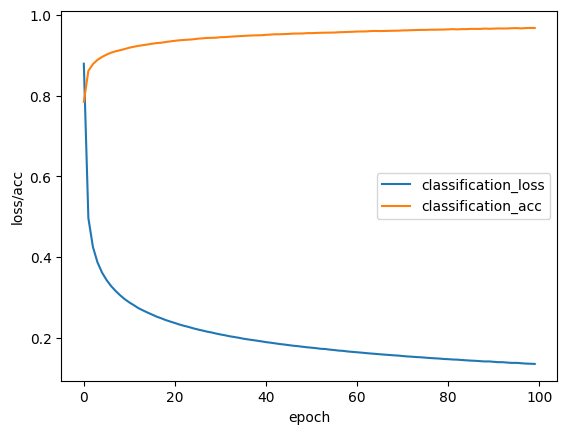

In [ ]:
plt.xlabel('epoch')
plt.ylabel('loss/acc')
plt.plot(model.classifier_loss_history, label=f'classification_loss')
plt.plot(model.classifier_acc_history, label=f'classification_acc')
plt.legend()

In [ ]:
test_set = MNIST('./data/', train=False, download=True)
x_test = test_set.data.type(torch.float32) / 255
x_test = to_binary(x_test, 0.5).unsqueeze(1)

preds = model.classifier(x_test)

# accuracy
acc = (preds.cpu() == test_set.targets).to(torch.float).mean().item()
print('Acc:', acc)

# f1-score
from sklearn.metrics import f1_score

f1_score = f1_score(test_set.targets, preds.cpu(), average='macro')
print('f1-score:', f1_score)

100%|██████████| 20/20 [00:00<00:00, 233.15it/s]


Acc: 0.8808000087738037
f1-score: 0.879591653088412
